In [34]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

In [35]:
df = pd.read_csv("/Users/pietrovolpato/Downloads/archive-2/transfermarkt_fbref_201819.csv", delimiter=';')
df.drop("Column1", inplace = True, axis = 1)

/var/folders/p9/0gln4v894554660_ck8t4vtc0000gn/T/ipykernel_1036/1771987609.py:1: DtypeWarning: Columns (395) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/pietrovolpato/Downloads/archive-2/transfermarkt_fbref_201819.csv", delimiter=';')


In [36]:
def num_vars(df):
    return  df.select_dtypes(include=['number']).columns

In [37]:
df.height = df.height.astype('float')

In [38]:
df.head()

,player,nationality,position,squad,age,birth_year,value,height,position2,foot,...,Pts/G,xG,xGA,xGDiff,xGDiff/90,Attendance,CL,WinCL,CLBestScorer,Season
0,Borja Bastón,es ESP,FW,Alavés,25.0,1992.0,2000000.0,186.0,Forward - Centre-Forward,right,...,1.32,37.3,50.8,-13.5,-0.36,"17,295",0.0,0.0,0,201819#
1,Burgui,es ESP,"MF,FW",Alavés,24.0,1993.0,1500000.0,184.0,Forward - Left Winger,right,...,1.32,37.3,50.8,-13.5,-0.36,"17,295",0.0,0.0,0,201819#
2,Jonathan Calleri,ar ARG,FW,Alavés,24.0,1993.0,9000000.0,181.0,Forward - Centre-Forward,right,...,1.32,37.3,50.8,-13.5,-0.36,"17,295",0.0,0.0,0,201819#
3,Rubén Duarte,es ESP,DF,Alavés,22.0,1995.0,5000000.0,172.0,Defender - Left-Back,left,...,1.32,37.3,50.8,-13.5,-0.36,"17,295",0.0,0.0,0,201819#
4,Rodrigo Ely,br BRA,DF,Alavés,24.0,1993.0,2000000.0,188.0,Defender - Centre-Back,right,...,1.32,37.3,50.8,-13.5,-0.36,"17,295",0.0,0.0,0,201819#


In [39]:
df.drop("Season", axis = 1, inplace = True) #Dropped because all 18-19

In [40]:
df.drop("MP", axis = 1, inplace = True) #Dropped because all almost same

In [41]:
df.dropna(subset=['value'], inplace=True) #Removed rows which had value = NA, not needed in analysis

There were some NAs, which were manually replaced with their real value by looking online

In [42]:
columns_with_na = df.columns[df.isna().any()].tolist()

rows_with_na_index = df[df.isna().any(axis=1)].index.tolist()

df.loc[df.player == "Adrián Diéguez"  ,"foot"] = "left"
df.loc[df.player == "Hervé Lybohy"  ,"foot"] = "left"
df.loc[df.player == "Hervé Lybohy"  ,"height"] = "187.0"
df.loc[df.player == "Juan Soriano"  ,"foot"] = "right"

df.isna().any().any()

False

From string to binary for foot variable

In [43]:
df["foot"].replace("left", 0, inplace = True)
df["foot"].replace("right", 1, inplace = True)

In [44]:
df["position"] = df["position"].apply(lambda x: str(x[:2]) if len(x)>2 else x)

df.drop("position2", inplace = True, axis = 1)

In [45]:
df.drop("Attendance", axis = 1, inplace = True) #Useless the n of people in a stadium

In [46]:
df.drop("birth_year", axis = 1, inplace = True) #We have age

In [47]:
gk_vars = [x for x in df.columns if "gk" in x ]

players_vars = list(set(df.columns) -  set(gk_vars))

players_vars = [x for x in df.columns if x in players_vars]

players_df = df.loc[df.position != 'GK', players_vars]

Took only the main position for players which had 2 and removed the specific position to reduce number of levels

There were some variables with gk inside, related solely to goalkeepers. Subsetted only our variables of interested an reordered them as in the original DF

Removed variables in which entries equal to 0 are more than 95% (not 90 becasue we had variables of interest, done to remove gk-related variables)
'WinCL','CLBestScorer' not removed because they are not gk_related (reason of the [:-2])

In [48]:
to_rem = num_vars(players_df)[np.sum(players_df[num_vars(players_df)] == 0, axis = 0)/players_df.shape[0]>0.95]

In [49]:
to_rem

Index(['shots_on_target_against', 'saves', 'save_pct', 'clean_sheets',
       'clean_sheets_pct', 'pens_allowed', 'pens_saved',
       'psnpxg_per_shot_on_target_against', 'goal_kicks',
       'pct_goal_kicks_launched', 'goal_kick_length_avg',
       'shots_on_target_againstm', 'savesm', 'save_pctm', 'clean_sheetsm',
       'clean_sheets_pctm', 'pens_allowedm', 'pens_savedm',
       'psnpxg_per_shot_on_target_againstm', 'goal_kicksm',
       'pct_goal_kicks_launchedm', 'goal_kick_length_avgm', 'WinCL',
       'CLBestScorer'],
      dtype='object')

In [50]:
players_df.drop(to_rem, axis = 1, inplace=True)

In [51]:
# Identify duplicate players
player_dupl = players_df['player'].value_counts()
player_dupl = player_dupl[player_dupl > 1].index.tolist()

# Initialize a list to store indices of rows to be dropped
rows_to_drop = []

# Iterate over duplicate players
for player in player_dupl:
    temp = players_df[players_df['player'] == player]
    
    # Determine which row to drop based on the 'games' column
    if temp.iloc[0]['games'] > temp.iloc[1]['games']:
        idx = temp[temp['games'] == temp.iloc[1]['games']].index
    else:
        idx = temp[temp['games'] == temp.iloc[0]['games']].index
    
    # Append the indices to the list
    rows_to_drop.extend(idx)

# Drop the identified rows
players_df = players_df.drop(rows_to_drop)

In [52]:
colors = ["#FF0B04", "#4374B3","#009490"]
custom_palette = sns.color_palette(colors)
sns.set_palette(custom_palette)

<AxesSubplot: >

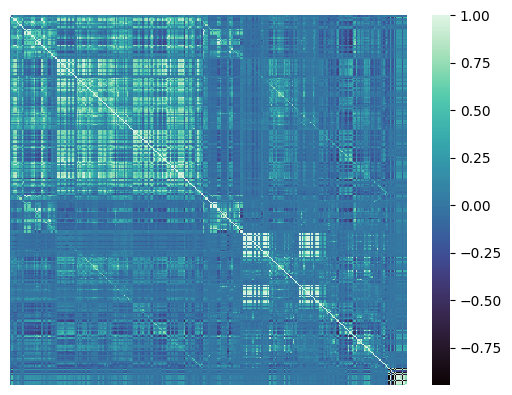

In [53]:
sns.heatmap(players_df[num_vars(players_df)].corr(), yticklabels=False, xticklabels= False, cmap = sns.color_palette("mako", as_cmap=True))

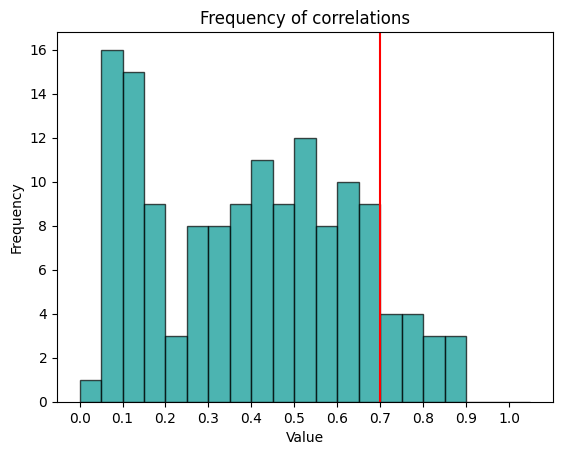

In [54]:
numerical_variables = num_vars(players_df)
dupl = [x+'m' for x in numerical_variables if x+'m'  in numerical_variables]

corr_value = [players_df.loc[:,[x[:len(x)-1],x]].corr().iloc[0,1] for x in dupl]

corr_dict = {k:round(v,3) for k,v in zip(dupl, corr_value)}

bins = np.arange(0, 1.1, 0.05)
plt.hist(corr_dict.values(), bins=bins, edgecolor='black', alpha=0.7, color = "#009490")
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency of correlations')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.axvline(x = 0.7, color = "red")
plt.show()

In [55]:
to_rem = [x for x,v in corr_dict.items() if v > 0.7]

players_df.drop(to_rem, inplace = True, axis = 1)

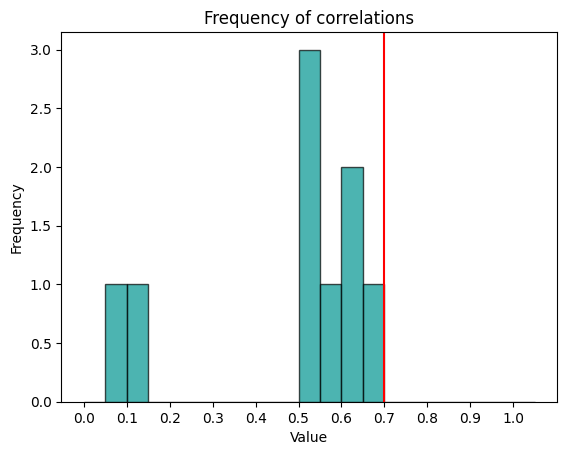

In [56]:
numerical_variables = num_vars(players_df)
dupl = [x for x in numerical_variables if x+'_per90'  in numerical_variables]

corr_value = [players_df.loc[:,(x,x+'m')].corr().iloc[0,1] for x in dupl]

corr_dict = {k:round(v,3) for k,v in zip(dupl, corr_value)}

bins = np.arange(0, 1.1, 0.05)
plt.hist(corr_dict.values(), bins=bins, edgecolor='black', alpha=0.7,color = "#009490")
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency of correlations')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.axvline(x = 0.7, color = "red")
plt.show()

In [57]:
corr_mat = players_df[num_vars(players_df)].corr()

corr_mat = corr_mat[corr_mat > 0.9]
for i in range(corr_mat.shape[0]): 
    corr_mat.iloc[i,i] = np.nan

In [58]:
corr_dict = {k:[] for k in corr_mat.columns}
for i in corr_mat.columns:
    corr_dict[i] = list(corr_mat.columns[~corr_mat[i].isna()])
corr_dict = {k:v for k,v in corr_dict.items() if len(v) > 0}

### Passes

In [59]:
passes_cols = [x for x in players_df.columns if "pass" in x]

In [60]:
temp = players_df[passes_cols[:int(len(passes_cols)/2)]].corr()
for i in temp.columns:
    temp.loc[i,i] = 0
temp[temp>0.7]

,passes_completed,passes,passes_pct,passes_total_distance,passes_progressive_distance,passes_completed_short,passes_short,passes_pct_short,passes_completed_medium,passes_medium,...,passes_oob,passes_intercepted,passes_blocked,sca_passes_live,sca_passes_dead,gca_passes_live,gca_passes_dead,blocked_passes,pass_targets,passes_received
passes_completed,NaN,0.991359,NaN,0.982898,0.928683,0.922349,0.909475,NaN,0.974471,0.982814,...,0.739876,0.715824,NaN,NaN,NaN,NaN,NaN,0.710923,0.866253,0.954924
passes,0.991359,NaN,NaN,0.969912,0.932822,0.930273,0.925718,NaN,0.952911,0.974545,...,0.795712,0.768272,NaN,NaN,NaN,NaN,NaN,0.761578,0.883717,0.957863
passes_pct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passes_total_distance,0.982898,0.969912,NaN,NaN,0.952932,0.838428,0.822739,NaN,0.989414,0.989422,...,0.750998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.811168,0.919121
passes_progressive_distance,0.928683,0.932822,NaN,0.952932,NaN,0.778267,0.764440,NaN,0.944373,0.956127,...,0.786012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.721141,0.841166
passes_completed_short,0.922349,0.930273,NaN,0.838428,0.778267,NaN,0.996625,NaN,0.820137,0.849313,...,NaN,0.821012,0.712506,0.754663,NaN,NaN,NaN,0.742809,0.894094,0.928154
passes_short,0.909475,0.925718,NaN,0.822739,0.764440,0.996625,NaN,NaN,0.800699,0.836208,...,NaN,0.845362,0.747932,0.784476,NaN,NaN,NaN,0.760622,0.907567,0.927061
passes_pct_short,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passes_completed_medium,0.974471,0.952911,NaN,0.989414,0.944373,0.820137,0.800699,NaN,NaN,0.993972,...,0.711580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.782196,0.898928
passes_medium,0.982814,0.974545,NaN,0.989422,0.956127,0.849313,0.836208,NaN,0.993972,NaN,...,0.760440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.811557,0.916434


In [61]:
players_df.drop(["passes_completed"], axis = 1, inplace = True) #We have passes pct which is the ratio of 2 cols.
players_df.drop(["passes_completedm","passesm"], axis = 1, inplace = True) #We have passes pct which is the ratio of 2 cols.

In [62]:
players_df.drop(["progressive_passes", "progressive_passesm"], axis = 1, inplace = True) #Highly correlated with 

In [63]:
players_df.drop(["passes_short","passes_completed_short"], axis = 1, inplace = True)
players_df.drop(["passes_medium","passes_completed_medium"], axis = 1, inplace = True)
players_df.drop(["passes_long","passes_completed_long"], axis = 1, inplace = True)

In [64]:
players_df.drop(["passes_shortm","passes_completed_shortm"], axis = 1, inplace = True)
players_df.drop(["passes_mediumm","passes_completed_mediumm"], axis = 1, inplace = True)
players_df.drop(["passes_longm","passes_completed_longm"], axis = 1, inplace = True)

In [65]:
players_df.drop(["pass_targets","passes_received","passes_receivedm","pass_targetsm"],inplace = True, axis = 1)

In [66]:
players_df["passes_progressive_ratio"] = players_df.passes_progressive_distance / players_df.passes_total_distance

In [67]:
players_df.drop(["passes_progressive_distance","passes_progressive_distancem"], axis = 1, inplace = True)

In [68]:
players_df.drop(["blocked_passes","blocked_passesm"], axis = 1, inplace = True)

In [69]:
players_df.drop(["passes_total_distance"], axis = 1, inplace = True)

In [70]:
players_df.drop(["passes_live","passes_livem"], axis = 1, inplace = True)

### Goals

In [71]:
goal_cols = [x for x in players_df.columns if "goal" in x]

temp = players_df[goal_cols[:len(goal_cols)]].corr()
for i in temp.columns:
    temp.loc[i,i] = 0
temp[temp>0.7]

,goals,goals_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,goals_per_shot,goals_per_shot_on_target,own_goals,goalsm,goals_per90m,goals_assists_per90m,goals_pens_per90m,goals_assists_pens_per90m,goals_per_shotm,goals_per_shot_on_targetm,own_goalsm
goals,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
goals_per90,NaN,NaN,0.903659,0.987125,0.893247,NaN,NaN,NaN,0.999957,NaN,NaN,NaN,NaN,NaN,0.707281,NaN
goals_assists_per90,NaN,0.903659,NaN,0.885301,0.991855,NaN,NaN,NaN,0.903552,NaN,NaN,NaN,NaN,NaN,NaN,NaN
goals_pens_per90,NaN,0.987125,0.885301,NaN,0.895193,NaN,NaN,NaN,0.987117,NaN,NaN,NaN,NaN,NaN,0.740418,NaN
goals_assists_pens_per90,NaN,0.893247,0.991855,0.895193,NaN,NaN,NaN,NaN,0.893149,NaN,NaN,NaN,NaN,NaN,NaN,NaN
goals_per_shot,NaN,NaN,NaN,NaN,NaN,NaN,0.806217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
goals_per_shot_on_target,NaN,NaN,NaN,NaN,NaN,0.806217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
own_goals,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
goalsm,NaN,0.999957,0.903552,0.987117,0.893149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.707384,NaN
goals_per90m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.984656,0.999861,0.984676,NaN,0.886180,NaN


In [72]:
players_df["goal_accuracy"] = players_df.goals_per_shot / players_df.goals_per_shot_on_target
players_df["goal_accuracym"] = players_df.goals_per_shotm / players_df.goals_per_shot_on_targetm
players_df.drop(["goals_per_shot" ,"goals_per_shot_on_target"], axis = 1, inplace = True)
players_df.drop(["goals_per_shotm" ,"goals_per_shot_on_targetm"], axis = 1, inplace = True)

In [73]:
players_df.drop("goal_accuracym", axis = 1, inplace = True)

In [74]:
players_df.drop(["goals_pens_per90m", "goals_pens_per90"] , axis = 1, inplace = True)

In [75]:
players_df.drop("goals_assists_per90", axis = 1, inplace = True)

In [76]:
players_df.drop(["goals_per90","goals_per90m"], axis = 1, inplace = True)

In [77]:
players_df.drop(["goals_assists_pens_per90","goals_assists_pens_per90m"], axis = 1, inplace = True)

### Penalty

In [78]:
pen = [x for x in players_df.columns if "pen" in x]
temp = players_df[pen[:len(pen)]].corr()
for i in temp.columns:
    temp.loc[i,i] = 0
temp[temp>0.7]

,pens_made,pens_att,passes_into_penalty_area,crosses_into_penalty_area,touches_def_pen_area,touches_att_pen_area,pens_won,pens_conceded,passes_into_penalty_aream,crosses_into_penalty_aream,touches_att_pen_aream,pens_wonm,pens_concededm
pens_made,NaN,0.968729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pens_att,0.968729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passes_into_penalty_area,NaN,NaN,NaN,0.750846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
crosses_into_penalty_area,NaN,NaN,0.750846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
touches_def_pen_area,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
touches_att_pen_area,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pens_won,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pens_conceded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passes_into_penalty_aream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
crosses_into_penalty_aream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
players_df["pens_converted"] = players_df.pens_made/players_df.pens_att
players_df.drop(["pens_made","pens_att"],axis = 1, inplace = True)

### per_90 and m

In [80]:
prova = [x for x in num_vars(players_df) if x+'m' in num_vars(players_df) and x+'_per90' in num_vars(players_df)]

In [81]:
for x in prova:
    if players_df[[x+'m',x+'_per90']].corr().iloc[0,1] > 0.7:
        print(x)

assists
xg
npxg
xa
shots_total
shots_on_target


### Expected

In [82]:
expected = [x for x in players_df.columns if "x" in x]
expected
temp = players_df[expected[:len(expected)]].corr()
for i in temp.columns:
    temp.loc[i,i] = 0
temp[temp>0.7]

,xg,npxg,xa,xg_per90,xa_per90,xg_xa_per90,npxg_per90,npxg_xa_per90,npxg_per_shot,xg_net,...,npxg_per90m,npxg_xa_per90m,npxg_per_shotm,xg_netm,npxg_netm,xa_netm,xG,xGA,xGDiff,xGDiff/90
xg,NaN,0.981786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
npxg,0.981786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xg_per90,NaN,NaN,NaN,NaN,NaN,0.906207,0.981723,0.889658,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xa_per90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xg_xa_per90,NaN,NaN,NaN,0.906207,NaN,NaN,0.883464,0.988784,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
npxg_per90,NaN,NaN,NaN,0.981723,NaN,0.883464,NaN,0.895242,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
npxg_xa_per90,NaN,NaN,NaN,0.889658,NaN,0.988784,0.895242,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
npxg_per_shot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xg_net,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
players_df.drop(["npxg"],axis = 1, inplace = True)
players_df.drop(["npxg_per90","npxg_per90m"],axis = 1, inplace = True)

In [84]:
players_df.drop(["xg_xa_per90","npxg_xa_per90","npxg_xa_per90m","xg_xa_per90m"],axis = 1, inplace = True)

In [85]:
players_df.drop(["npxg_net","npxg_netm"], axis = 1, inplace = True)

In [86]:
players_df.drop(["xGDiff","xGDiff/90"], axis = 1, inplace = True)

In [87]:
players_df.drop("npxg_per_shotm", axis = 1, inplace = True)

### Pressure

In [88]:
expected = [x for x in players_df.columns if "pressure" in x]
expected
temp = players_df[expected[:len(expected)]].corr()
for i in temp.columns:
    temp.loc[i,i] = 0
temp[temp>0.7]

,passes_pressure,pressures,pressure_regains,pressure_regain_pct,pressures_def_3rd,pressures_mid_3rd,pressures_att_3rd,passes_pressurem,pressuresm,pressure_regainsm,pressure_regain_pctm,pressures_def_3rdm,pressures_mid_3rdm,pressures_att_3rdm
passes_pressure,NaN,0.778811,0.828080,NaN,0.741852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pressures,0.778811,NaN,0.966488,NaN,0.729931,0.965075,0.737152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pressure_regains,0.828080,0.966488,NaN,NaN,0.786027,0.911005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pressure_regain_pct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pressures_def_3rd,0.741852,0.729931,0.786027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pressures_mid_3rd,NaN,0.965075,0.911005,NaN,NaN,NaN,0.726276,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pressures_att_3rd,NaN,0.737152,NaN,NaN,NaN,0.726276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passes_pressurem,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pressuresm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.843329,NaN
pressure_regainsm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
players_df.drop(["pressures","pressuresm"], axis = 1, inplace = True)
players_df.drop(["pressure_regains", "pressure_regainsm"], axis = 1, inplace = True)

### sca and Gca

In [90]:
expected = [x for x in players_df.columns if "gca" in x or "sca" in x]
temp = players_df[expected[:len(expected)]].corr()
for i in temp.columns:
    temp.loc[i,i] = 0
temp = temp[temp>0.9]
temp.dropna(axis = "columns", how = "all", inplace = True)
temp.dropna(axis = "rows", how = "all", inplace = True)

In [91]:
temp

,sca,sca_passes_live,gca,gca_passes_live,scam,sca_passes_livem,sca_shotsm,sca_fouledm,gcam,gca_passes_livem,gca_fouledm,gca_og_form
sca,NaN,0.97017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sca_passes_live,0.97017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gca,NaN,NaN,NaN,0.94157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gca_passes_live,NaN,NaN,0.94157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scam,NaN,NaN,NaN,NaN,NaN,0.998435,0.947831,0.980790,0.979427,0.970854,0.956206,0.971602
sca_passes_livem,NaN,NaN,NaN,NaN,0.998435,NaN,0.936619,0.972956,0.976140,0.969086,0.949160,0.966945
sca_shotsm,NaN,NaN,NaN,NaN,0.947831,0.936619,NaN,0.941821,0.944381,0.934111,0.914992,0.947573
sca_fouledm,NaN,NaN,NaN,NaN,0.980790,0.972956,0.941821,NaN,0.973926,0.963879,0.965108,0.974345
gcam,NaN,NaN,NaN,NaN,0.979427,0.976140,0.944381,0.973926,NaN,0.996866,0.959000,0.976646
gca_passes_livem,NaN,NaN,NaN,NaN,0.970854,0.969086,0.934111,0.963879,0.996866,NaN,0.941985,0.969259


In [92]:
players_df["gca_summarym"] = 3/8 * players_df.gcam + 2/8 * players_df.gca_passes_livem + 2/8 * (players_df.gca_fouledm + players_df.gca_og_form)
players_df.drop(["gcam","gca_passes_livem","gca_fouledm","gca_og_form"], axis= 1, inplace = True)

In [93]:
players_df["sca_summarym"] = 3/8*players_df.scam+ 2/8 * players_df.sca_passes_livem + 2/8 * players_df.sca_shotsm + 1/8 * players_df.sca_fouledm
players_df.drop(["sca_passes_livem","sca_shotsm","sca_fouledm", "scam"], axis = 1, inplace = True)

In [94]:
players_df.drop(["sca_passes_live","gca_passes_live"], axis = 1, inplace = True)

In [95]:
players_df["gca/sca_summarym"] = 5/8 * players_df.gca_summarym + 3/8 * players_df.sca_summarym 

In [96]:
players_df.drop(["gca_summarym","sca_summarym"], axis = 1, inplace = True)

### Shots

In [97]:
expected = [x for x in players_df.columns if "shot" in x]
expected
temp = players_df[expected[:len(expected)]].corr()
for i in temp.columns:
    temp.loc[i,i] = 0
temp[temp>0.7]

,shots_total,shots_on_target,shots_free_kicks,shots_on_target_pct,shots_total_per90,shots_on_target_per90,npxg_per_shot,assisted_shots,sca_shots,gca_shots,blocked_shots,blocked_shots_saves,shots_totalm,shots_on_targetm,shots_on_target_pctm,shots_total_per90m,shots_on_target_per90m,assisted_shotsm,gca_shotsm,blocked_shotsm
shots_total,NaN,0.952189,NaN,NaN,NaN,NaN,NaN,NaN,0.824118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shots_on_target,0.952189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.783604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shots_free_kicks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shots_on_target_pct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shots_total_per90,NaN,NaN,NaN,NaN,NaN,0.730028,NaN,NaN,NaN,NaN,NaN,NaN,0.999998,0.729998,NaN,NaN,NaN,NaN,NaN,NaN
shots_on_target_per90,NaN,NaN,NaN,NaN,0.730028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.730011,0.999986,NaN,NaN,NaN,NaN,NaN,NaN
npxg_per_shot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
assisted_shots,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sca_shots,0.824118,0.783604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gca_shots,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
players_df.drop("shots_on_target", axis = 1, inplace = True) #We have the pct

### Touches

In [99]:
expected = [x for x in players_df.columns if "touches" in x]
expected
temp = players_df[expected[:len(expected)]].corr()
for i in temp.columns:
    temp.loc[i,i] = 0
temp[temp>0.7]

,touches,touches_def_pen_area,touches_def_3rd,touches_mid_3rd,touches_att_3rd,touches_att_pen_area,touches_live_ball,touchesm,touches_def_3rdm,touches_mid_3rdm,touches_att_3rdm,touches_att_pen_aream,touches_live_ballm
touches,NaN,NaN,0.770840,0.970489,NaN,NaN,0.995027,NaN,NaN,NaN,NaN,NaN,NaN
touches_def_pen_area,NaN,NaN,0.947045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
touches_def_3rd,0.770840,0.947045,NaN,0.730782,NaN,NaN,0.775833,NaN,NaN,NaN,NaN,NaN,NaN
touches_mid_3rd,0.970489,NaN,0.730782,NaN,NaN,NaN,0.974365,NaN,NaN,NaN,NaN,NaN,NaN
touches_att_3rd,NaN,NaN,NaN,NaN,NaN,0.764538,NaN,NaN,NaN,NaN,NaN,NaN,NaN
touches_att_pen_area,NaN,NaN,NaN,NaN,0.764538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
touches_live_ball,0.995027,NaN,0.775833,0.974365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
touchesm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.889127,NaN,NaN,0.983640
touches_def_3rdm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
touches_mid_3rdm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.889127,NaN,NaN,NaN,NaN,0.891604


In [100]:
players_df.drop(["touches_def_pen_area"], axis = 1, inplace = True) #def_3rd
players_df.drop(["touches_live_ball","touches_live_ballm"], axis = 1, inplace = True) #99% with touches and touchesm

In [101]:
players_df.drop(["touches_mid_3rd","touches_mid_3rdm"], axis = 1, inplace = True)

### Tackles

In [102]:
expected = [x for x in players_df.columns if "tackle" in x]
expected
temp = players_df[expected[:len(expected)]].corr()
for i in temp.columns:
    temp.loc[i,i] = 0
temp[temp>0.7]

,tackles,tackles_won,tackles_def_3rd,tackles_mid_3rd,tackles_att_3rd,dribble_tackles,dribble_tackles_pct,tacklesm,tackles_wonm,tackles_def_3rdm,tackles_mid_3rdm,tackles_att_3rdm,dribble_tacklesm,dribble_tackles_pctm
tackles,NaN,0.975367,0.919088,0.909126,NaN,0.923292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tackles_won,0.975367,NaN,0.864414,0.921407,NaN,0.884900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tackles_def_3rd,0.919088,0.864414,NaN,NaN,NaN,0.894175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tackles_mid_3rd,0.909126,0.921407,NaN,NaN,NaN,0.797344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tackles_att_3rd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dribble_tackles,0.923292,0.884900,0.894175,0.797344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dribble_tackles_pct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tacklesm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.883539,NaN,0.775219,NaN,NaN,NaN
tackles_wonm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.883539,NaN,NaN,0.782457,NaN,NaN,NaN
tackles_def_3rdm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
players_df["tackles_pct"] = players_df.tackles_won / (players_df.tackles + 0.5)
players_df["tackles_pctm"] = players_df.tackles_wonm / players_df.tacklesm

In [104]:
players_df.drop(["tackles_won","tackles_wonm"], axis = 1, inplace = True)

In [105]:
players_df.drop(["dribble_tackles","dribble_tacklesm"], axis = 1, inplace = True) #Redundant 

In [106]:
players_df.drop("tackles_pctm", axis = 1, inplace = True)

In [107]:
players_df.drop(["tackles", "tacklesm"], axis = 1, inplace = True)

### Crosses

In [108]:
expected = [x for x in players_df.columns if "crosses" in x]
expected
temp = players_df[expected[:len(expected)]].corr()
for i in temp.columns:
    temp.loc[i,i] = 0
temp[temp>0.7]

,crosses_into_penalty_area,crosses,crosses_into_penalty_aream,crossesm
crosses_into_penalty_area,NaN,0.921699,NaN,NaN
crosses,0.921699,NaN,NaN,NaN
crosses_into_penalty_aream,NaN,NaN,NaN,NaN
crossesm,NaN,NaN,NaN,NaN


In [109]:
players_df["crosses_pen_pct"] = players_df.crosses_into_penalty_area / (players_df.crosses + 0.5)
players_df.drop("crosses_into_penalty_area", axis = 1, inplace = True)

### Dribles

In [110]:
expected = [x for x in players_df.columns if "dribble" in x]
temp = players_df[expected[:len(expected)]].corr()
for i in temp.columns:
    temp.loc[i,i] = 0
temp[temp>0.7]

,sca_dribbles,gca_dribbles,dribbles_vs,dribble_tackles_pct,dribbled_past,dribbles_completed,dribbles,dribbles_completed_pct,players_dribbled_past,sca_dribblesm,gca_dribblesm,dribbles_vsm,dribble_tackles_pctm,dribbled_pastm,dribbles_completedm,dribblesm,dribbles_completed_pctm,players_dribbled_pastm
sca_dribbles,NaN,NaN,NaN,NaN,NaN,0.825912,0.838131,NaN,0.830257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gca_dribbles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dribbles_vs,NaN,NaN,NaN,NaN,0.970024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dribble_tackles_pct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dribbled_past,NaN,NaN,0.970024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dribbles_completed,0.825912,NaN,NaN,NaN,NaN,NaN,0.982443,NaN,0.997914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dribbles,0.838131,NaN,NaN,NaN,NaN,0.982443,NaN,NaN,0.986959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dribbles_completed_pct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
players_dribbled_past,0.830257,NaN,NaN,NaN,NaN,0.997914,0.986959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sca_dribblesm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
players_df["dribles_compl_pct"] = players_df.dribbles_completed / players_df.dribbles
players_df.drop("dribbles_completed", axis = 1, inplace = True)

In [112]:
players_df["dribles_compl_pctm"] = players_df.dribbles_completedm / players_df.dribblesm
players_df.drop("dribbles_completedm", axis = 1, inplace = True)

In [113]:
players_df["past_over_vs_dribbles"] = players_df.dribbled_past / players_df.dribbles_vs
players_df.drop("dribbled_past", axis = 1, inplace = True)

players_df["past_over_vs_dribblesm"] = players_df.dribbled_pastm / players_df.dribbles_vsm
players_df.drop("dribbled_pastm", axis = 1, inplace = True)

In [114]:
players_df.drop(["players_dribbled_past","players_dribbled_pastm"], axis = 1, inplace = True)

In [115]:
players_df.drop(["dribles_compl_pctm", "past_over_vs_dribblesm"], axis = 1, inplace = True)

### Distance

In [116]:
expected = [x for x in players_df.columns if "distance" in x]
temp = players_df[expected[:len(expected)]].corr()
for i in temp.columns:
    temp.loc[i,i] = 0
temp[temp>0.7]

,carry_distance,carry_progressive_distance,passes_total_distancem,carry_distancem,carry_progressive_distancem
carry_distance,NaN,0.985131,NaN,NaN,NaN
carry_progressive_distance,0.985131,NaN,NaN,NaN,NaN
passes_total_distancem,NaN,NaN,NaN,NaN,NaN
carry_distancem,NaN,NaN,NaN,NaN,0.885905
carry_progressive_distancem,NaN,NaN,NaN,0.885905,NaN


In [117]:
players_df["carry_progressive_distance_pct"] = players_df.carry_progressive_distance / players_df.carry_distance
players_df.drop("carry_progressive_distance", axis = 1, inplace = True)
players_df["carry_progressive_distance_pctm"] = players_df.carry_progressive_distancem / players_df.carry_distancem
players_df.drop("carry_progressive_distancem", axis = 1, inplace = True)

In [118]:
players_df.drop("carry_progressive_distance_pctm", axis = 1, inplace = True)

### Mixture

In [119]:
a = players_df[num_vars(players_df)].corr()
for i in range(a.shape[0]):
    a.iloc[i,i] = 0
a = a[a>0.8]
a.dropna(axis = "columns", how = "all", inplace = True)
a.dropna(axis = "rows", how = "all", inplace = True)

In [120]:
players_df.drop(["LgRk","W","L","GDiff","Pts/G","xG"], axis = 1, inplace = True)

In [121]:
players_df.drop(["GF","GA","xGA"], axis = 1, inplace = True)

In [122]:
players_df["games_started_pct"] = players_df.games_starts / players_df.games
players_df.drop(["games","games_starts"], axis = 1, inplace = True)

In [123]:
players_df["act_vs_exp_goals"] = players_df.goals / (players_df.xg + 0.5)
players_df.drop(["xg"], axis = 1, inplace = True)

In [124]:
players_df.drop("minutes_90s", axis = 1, inplace = True)

In [125]:
players_df["act_vs_exp_assists"] = players_df.assists / (players_df.xa + 0.5)
players_df.drop(["xa"], axis = 1, inplace = True)

In [126]:
players_df.drop("goal_accuracy", axis = 1, inplace = True)

In [127]:
players_df.drop(["touchesm","touches"], axis = 1, inplace =  True)

In [128]:
players_df.drop(["passes_groundm", "passes_ground"],axis = 1, inplace =  True)

In [129]:
players_df.drop(["assisted_shots","assisted_shotsm"], axis = 1, inplace = True)

In [130]:
players_df.drop(["carries","carriesm"], axis = 1, inplace = True)

In [131]:
players_df.drop(["passes_total_distancem"], axis = 1, inplace = True)

In [132]:
players_df.drop("dribles_compl_pct", axis = 1, inplace = True)

In [133]:
players_df.drop("passes_into_final_thirdm", axis = 1, inplace = True)

In [134]:
players_df.drop("passes_into_penalty_aream", axis = 1, inplace = True)